# CSCI 3352 Biological Networks, Spring 2023, Prof. Clauset
Submit here: https://canvas.colorado.edu/courses/91192

# Problem Set 7 : Network epidemiology


***

**Name**: ANNA HIRSCHMANN

NOTE: I completed this assignment individually. I used the internet when calculating the variance and mean of my distribution draws in order to create a function that calculated and returned these values. URL is included in the docstring of the function in question.

***

This assignment is due on Canvas by **11:55pm on Friday, March 17th**. Your solutions to non-programming questions should be done in Markdown directly below the associated question. Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own** (see syllabus for detailed guidance). There are 65 points total, and 20 pts extra credit.

**NOTES**: 

- Unless a url is given for a data set, you will find the required data on the course Canvas.
- If you're not familiar with typesetting math directly in Markdown, you may do your work on paper first and then typeset it later. This [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) provides helpful guidance for writing math in Markdown. 
- It is **unhelpful** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code.

***
* networkx [Documentation](https://networkx.github.io/documentation/stable/) and [Tutorial](https://networkx.github.io/documentation/stable/tutorial.html)
* igraph [Documentation](https://igraph.org/python/versions/latest/install.html) and [Tutorial](https://igraph.org/python/tutorial/0.9.8/tutorial.html)

In [1]:
import networkx as nx
import numpy as np
import copy
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
import random as rnd
rnd.seed()

In [2]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11d646','#11c6d6','#d67711','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    
    node_colors = []
    for i in G.nodes():
        if z[i]=='S':
            cid = 0
        if z[i]=='I':
            cid = 1
        if z[i]=='R':
            cid = 2
        node_colors.append(colors[int(cid)])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
    
    nx.draw_kamada_kawai(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it prettier
    #nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [3]:
def plot_epidemicDynamics(St,It,Rt):
    # DO NOT MODIFY THIS FUNCTION
    # This function plots the S(t),I(t),R(t) time series nicely
    # WARNING: function is optimistic: assumes inputs are properly formatted

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.plot(range(len(St)), St, 'bo-', alpha=0.5,label='S(t)')  # plot the S(t) time series
    plt.plot(range(len(It)), It, 'rv-', alpha=0.5,label='I(t)')  # plot the I(t) time series
    plt.plot(range(len(Rt)), Rt, 'gs-', alpha=0.5,label='R(t)')  # plot the R(t) time series
    plt.ylabel('number of nodes')
    plt.xlabel('time, t')
    plt.legend(loc='upper right');
    #ax1.set_xlim([0, 50])
    plt.show()
    return

***
## Part 1 (10 pts) : Warming up

* Using the SIR simulation code from the in-class lab, write a function `run_SIR(G,s,beta,gmma,flag)` that
  * takes as input a simple `networkx` graph, an integer `s` that specifies the _number_ of randomly chosen infected nodes at time $t=0$, choices of $\beta$ and $\gamma$, and a binary variable `flag` (`=0` means run silently; `=1` means display any intermediate outputs, like `drawGz()` or `print()` statements),
  * runs the simulation to its completion, and then
  * returns the $S(t)$, $I(t)$, $R(t)$ time series for the progression of the epidemic (for plotting using the `plot_epidemicDynamics()` function) _and_ a dictionary `xt` that stores for each node `i` the corresponding time `t` at which `i` became infected. You'll need to instrument the existing simulation code to track `xt` correctly.
  
* Then, apply your new function to the toy graph from the lecture notes and lab, with $s=1$ and $\beta=\gamma=0.3$, and plot the resulting time series.

In [11]:
def run_SIR(G,s,beta,gmma,flag):
    '''Runs a basic SIR epidemic simulation given the epidemic parameters beta and lambda, 
    a graph structure, and s = the seed number of infected individuals. The binary flag indicates
    whether intermediate information will be plotted or printed. This function is based on the code
    from the in-class lab.'''

    n  = G.order()
    zt = dict.fromkeys(range(n), 'S') # all nodes S, initially
    xt = dict.fromkeys(range(n), -1) # all nodes are not infected initially

    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t
    
    # INITIAL INFECTIONS
    # pick a random sample of 's' nodes to infect
    seeds = rnd.sample(range(0, n-1), s) # this ensures that all of the nodes picked are unique
    for i in seeds:
        zt[i] = 'I'
        xt[i] = 1
    t = 1
    
    Sc,Ic,Rc = n-s,s,0 # S,I,R node counts, initial
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    
    if flag:
        print(f'time step {t}')
        drawGz(G,zt)
    
    # RUN THE SIMULATION FOR LATER TIMESTEPS
    while any(xi == 'I' for xi in zt.values()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)
    
        # do S -> I transitions
        for e in G.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i]=='I' and zt[j]=='S' and zu[j]!='I':
                if rnd.random() < beta:
                    zu[j] = 'I'       # i infects j for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts
                    xt[j] = t # time that j was infected

            if zt[i]=='S' and zt[j]=='I' and zu[i]!='I':
                if rnd.random() < beta:
                    zu[i] = 'I'       # j infects i for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts
                    xt[i] = t # time that i was infected

        # do I -> R transitions
        for i in G.nodes():
            if zt[i] == 'I' and rnd.random() < gmma:
                zu[i] = 'R'           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts

        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1
        if flag:
            print(f'time step {t}')
            drawGz(G,zt)

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series

    return St,It,Rt,xt

In [12]:
#bool(1)

time step 1


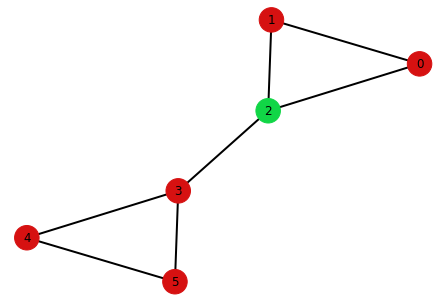

time step 2


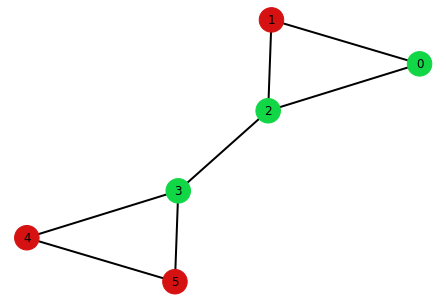

time step 3


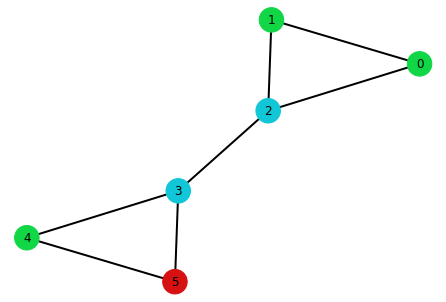

time step 4


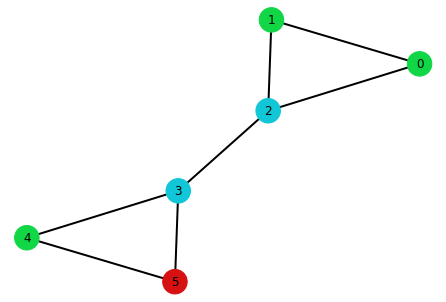

time step 5


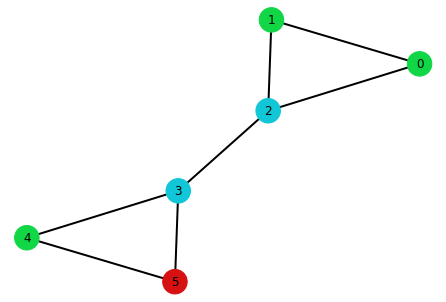

time step 6


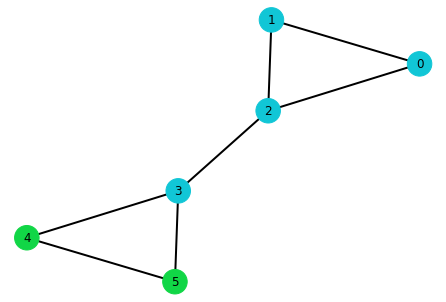

time step 7


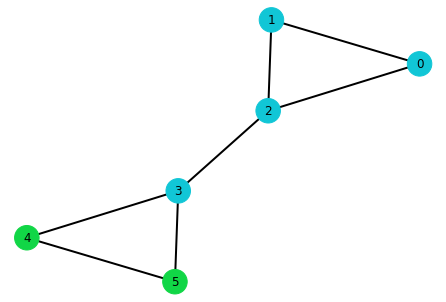

time step 8


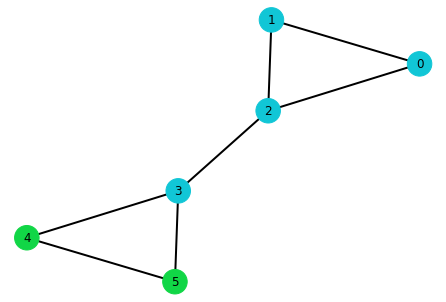

time step 9


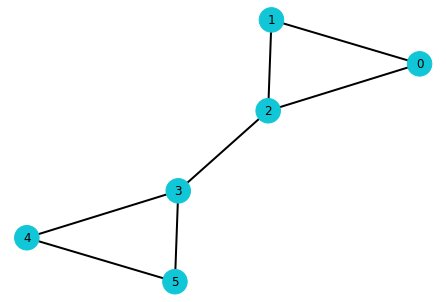

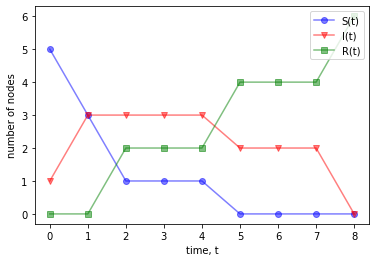

In [13]:
##### do not modify below here #####
##    run this code once you've written the run_SIR() function

G  = nx.Graph([(0,1),(0,2),(1,2),(2,3),(3,4),(3,5),(4,5)]) # a simple graph G

beta = 0.3
gmma = 0.3
flag = 1

St,It,Rt,xt = run_SIR(G,1,beta,gmma,flag)
plot_epidemicDynamics(St,It,Rt)

##### do not modify above here #####

***
## Problem 2 : The role of the degree distribution (55 pts total)

In this problem, you will investigate the role of the exposure graph's degree distribution $\Pr(k)$ on an epidemic's dynamics $I(t)$. This problem has three parts:
* `Problem 2-A`, you'll generate high/medium/low variance degree distributions.
* `Problem 2-B`, you'll run an epidemic on each and discuss the differences.
* `Problem 2-C`, you'll investigate the role of degree on _when_ a node gets infected.

### Problem 2-A (20 pts)

In `Problem 2-B` we'll use the Chung-Lu model to generate random graphs with a specified degree distribution. However, to see how varying the degree structure changes the epidemic's shape, we'll first need a low-dimensional way to vary the degree structure's shape. There are many ways to do this. Here, we'll use a 2-parameter distribution called a *stretched exponential*, which has the form:

<br/>
<center>$\Pr(x) \propto x^{\beta-1} \textrm{exp}(-\lambda \, x^{\beta})$,</center>

where $\beta\geq 0$ and $\lambda\geq 0$. When $\beta=1$, this distribution returns a standard (low variance) exponential distribution with parameter $\lambda$; when $\beta=2$, it decays like a standard (lower variance) Gaussian or Normal distribution; and when $\beta<1$, it decays more slowly than an exponential (higher variance). The parameter $\lambda$ is inversely related to the mean degree, so that $\lambda<1$ means a higher mean, and $\lambda>1$ means a lower mean.

* Use the provided function `drawFrom_SE(n,beta,lmbda)` to generate *three* lists, each containing $n=1000$ values. The three lists should be generated with different combinations of $\beta$ and $\lambda$, and should meet the following criteria:
  * one distribution should have "low" variance, one should have "high" variance, and one should be in between those, and
  * they should all have the roughly the same average value (e.g., in my solutions, the mean is about $2.3\pm0.1$).
* Modify the `plot_2CCDF()` function from `Problem Set 2` to display all three of these distributions together, i.e., make and apply a function `plot_3CCDF()`.
* Briefly describe the effect of increasing or decreasing $\beta$ and $\lambda$ on the shape of the plotted distributions, e.g., on the shape of the "body" (the middle part) and the upper tail of the distribution.

Hint: You will likely need to fiddle with different choices of parameters in order to find good settings. Try starting at $\beta=\lambda=1$, and then increasing or decreasing one, then the other parameter, until you get something reasonable when you plot it. For the "high" variance distribution, you'll want the maximum value you generate to be no higher than 100 or so.

In [34]:
def calc_mean_variance(lst):
    '''Calculates the mean and variance of a given list. 
    To create this function I researched how to calculate this online and used
    this website: https://www.geeksforgeeks.org/python-variance-of-list/'''
    mean = sum(lst) / len(lst)
    var = sum((i - mean) ** 2 for i in lst) / len(lst)
    return mean, var

In [35]:
def drawFrom_SE(n,beta,lmbda):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws n values from a stretched exponential distribution with parameters beta,lambda
    # and then rounds them to integers for use as degrees. It returns these in a list x.

    xmin = 0.5  # minimum value 
    x    = [] # 
    for i in range(n):
        xi = int(round( (xmin**beta - (1/lmbda)*np.log(1-rnd.random()))**(1/beta) ))
        x.append(xi)

    return x

In [36]:
test1 = drawFrom_SE(1000, 2, 0.15)
calc_mean_variance(test1)

(2.336, 1.217103999999996)

In [37]:
test2 = drawFrom_SE(1000, 1, 0.57)
calc_mean_variance(test2)

(2.298, 2.943195999999983)

In [38]:
test3 = drawFrom_SE(1000, 0.5, 1.5)
calc_mean_variance(test3)

(2.34, 6.8804000000001055)

In [39]:
low_variance = drawFrom_SE(1000, 4, 0.025)
mid_variance = drawFrom_SE(1000, 0.5, 1.5)
high_variance = drawFrom_SE(1000, 0.25, 3.77)

In [40]:
calc_mean_variance(low_variance)

(2.263, 0.4538309999999926)

In [41]:
calc_mean_variance(mid_variance)

(2.448, 6.421295999999917)

In [42]:
calc_mean_variance(high_variance)


(2.184, 10.222144000000169)

In [43]:
def plot_3CCDF(kis1,kis2,kis3):
    # based on plot_2CCDF from PS2
    # input : three lists of degrees
    # output: one plot showing the CCDFs of the three degree distributions Pr(K>=k) for k>=1
    
    one_max  = max(kis1)
    two_max = max(kis2)
    three_max = max(kis3)
    
    # histograms
    onecounts, onebins = np.histogram(kis1, bins=[i for i in range(one_max+2)], density=True)
    onecumcounts = np.cumsum(onecounts)
    onecumcounts = np.insert(onecumcounts,0,0)
    
    twocounts, twobins = np.histogram(kis2, bins=[i for i in range(two_max+2)], density=True)
    twocumcounts = np.cumsum(twocounts)
    twocumcounts = np.insert(twocumcounts,0,0)
    
    threecounts, threebins = np.histogram(kis3, bins=[i for i in range(three_max+2)], density=True)
    threecumcounts = np.cumsum(threecounts)
    threecumcounts = np.insert(threecumcounts,0,0)
    
    # plots
    fig = plt.figure(figsize=(12, 10)) # adjusted figsize to make figure larger
    ax1 = fig.add_subplot(111) # put multiple 
    plt.loglog(onebins[1:-1], 1-onecumcounts[1:-1], 'bs', alpha=0.5, label='low variance')
    plt.loglog(twobins[1:-1], 1-twocumcounts[1:-1], 'rs', alpha=0.5, label='mid variance')
    plt.loglog(threebins[1:-1], 1-threecumcounts[1:-1], 'gs', alpha=0.5, label='high variance')
    plt.title('CCDF, three degree distributions (loglog)')
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.legend(loc='upper right');
    plt.show()
    return

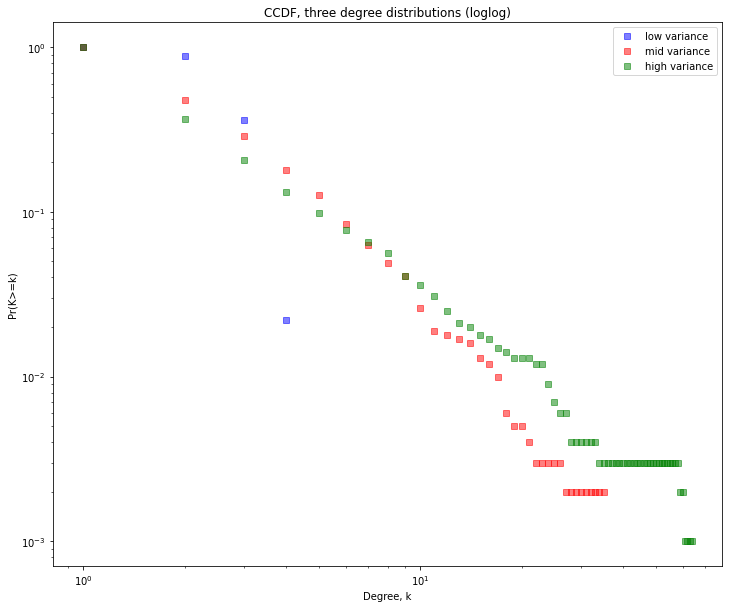

x1, mean = 2.267
x2, mean = 2.491
x3, mean = 2.436


In [44]:
n = 1000
beta1, beta2, beta3 = 4, 0.5, 0.25
lmbda1, lmbda2, lmbda3 = 0.025, 1.5, 3.77

##### do not modify below here #####
##    run this code once you've written the plot_3CCDF() function

x1 = drawFrom_SE(n,beta1,lmbda1)
x2 = drawFrom_SE(n,beta2,lmbda2)
x3 = drawFrom_SE(n,beta3,lmbda3)

plot_3CCDF(x1,x2,x3)

print(f'x1, mean = {sum(x1)/n}')
print(f'x2, mean = {sum(x2)/n}')
print(f'x3, mean = {sum(x3)/n}')

When beta is its highest and lambda is its lowest (low variance) the shape the CCDF takes is very rapidly decreasing. As beta decreases and lambda increases (in order to maintain mean) the decreasing shape becomes much more linear. The higher the variance (highest lambda, lowest beta) the wider the domain of the graph, i.e. the longer the upper tail. 

### Problem 2-B (15 pts)

Now, using $\beta=\gamma=0.4$ (at the critical threshold of $R_0$):
* Use the built-in `networkx` Chung-Lu graph generator to make a graph for each of your three degree distributions.
* Then, run your SIR simulation on each graph, and plot the corresponding epidemic's dynamics.
* Discuss what you see as differences or similarities among or between the three cases, and offer an explanation _in terms of the role that node degree plays in spreading the epidemic_. Remember that the _only_ thing different about these three graphs is the degree structure. (You may find it useful to use `drawGz()` to visualize them.)

Hint: You may need to re-run the simulation on the same graphs multiple times in order to get three good runs (since each run will start the epidemic in a different location, and occasionally the epidemic may not take off). Alternatively, you can increase the number of initially infected nodes to a small integer (maybe 5 at most). When comparing epidemics, don't forget to look at how _long_ they last.

-------------------- LOW VARIANCE --------------------


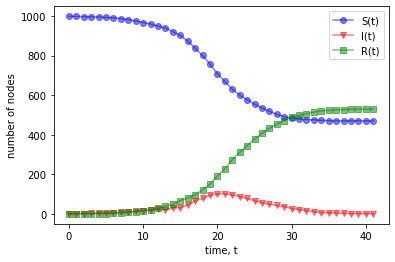


-------------------- MID VARIANCE --------------------


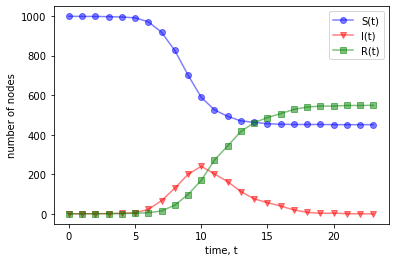


-------------------- HIGH VARIANCE --------------------


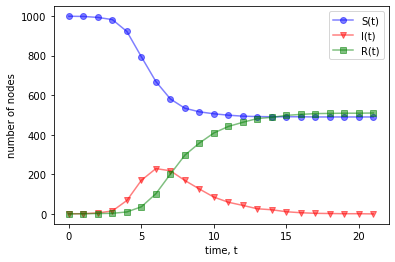

In [79]:
low_var_G = nx.expected_degree_graph(x1)
mid_var_G = nx.expected_degree_graph(x2)
high_var_G = nx.expected_degree_graph(x3)

beta = 0.4
gmma = 0.4
flag = 0

### LOW VARIANCE GRAPH
print('-------------------- LOW VARIANCE --------------------')
St_lv,It_lv,Rt_lv,xt_lv = run_SIR(low_var_G,1,beta,gmma,flag)
plot_epidemicDynamics(St_lv,It_lv,Rt_lv)

### MID VARIANCE GRAPH
print()
print('-------------------- MID VARIANCE --------------------')
St_mv,It_mv,Rt_mv,xt_mv = run_SIR(mid_var_G,1,beta,gmma,flag)
plot_epidemicDynamics(St_mv,It_mv,Rt_mv)

### HIGH VARIANCE GRAPH
print()
print('-------------------- HIGH VARIANCE --------------------')
St_hv,It_hv,Rt_hv,xt_hv = run_SIR(high_var_G,1,beta,gmma,flag)
plot_epidemicDynamics(St_hv,It_hv,Rt_hv)

The three graphs take on different SIR Curve shapes:
* **LOW VARIANCE**: Of the 1000 nodes, at the peak of the infection only about 100 are infected concurrently (size of the peak). We can see it takes a long time for the epidemic to run its full course, about 40 days (or other time units, but I will consider them days). The peak of the infection occurs around 20 days in.
* **MID VARIANCE**: In this graph, it takes the infection around 25 days to run its course, and it peaks around 9 days with over 200 people concurrently infected. Thus, we see that the epidemic is moving faster and infecting a larger portion of the population.
* **HIGH VARIANCE**: In this graph, we see a more severe version of the trends we saw in the medium variance version. The infection peaks even earlier (around 6 days) and the height of the peak is once again over 200. The full course of the infection is about 21 days.

This makes sense because higher variance in node degrees would allow certain nodes to take on significantly higher degrees. In terms of spread of infection, high degree nodes play a huge part in how many people get infected and how quickly. Because they are directly connected to so many other nodes, they can directly infect a number of people themselves. In addition, high degree nodes make the shortest paths from one node to another shorter, which means the infection can catch nodes quicker. 

### Problem 2-C (20 pts)

High degree nodes, which are more common under high variance degree distributions, play a special role in epidemics. Let's investigate.
* Using the `xt` output variable from your `run_SIR()` function, make three scatter plots of the time of infection $t_i$ as a function of node degree $k_i$, one for each network.
* For each plot, calculate and report the correlation coefficient `r = np.corrcoef(x,y)[0,1]` between your $x$ and $y$ variables.
* Finally, discuss any patterns you see within and across your high/medium/low variance networks from this perspective, and use the correlation coefficients you calculate to offer an explanation (in terms of the network structure and the rules of the SIR epidemic) as to why that pattern exists.

Hint: Don't plot values where $t_i=-1$, which is a special value indicating that node $i$ was never infected.

In [80]:
def plot_degree_vs_infectiontime(G, xt, title, color):
    degrees = dict(G.degree())
    plt.figure(figsize=(10, 7))
    xvals, yvals = [], []
    
    for i in range(G.order()):
        if xt[i] != -1:
            xvals.append(degrees[i])
            yvals.append(xt[i])
            plt.plot(degrees[i], xt[i], 'o', color=color)
    
    plt.title(title, fontsize=18)
    plt.xlabel('Node Degree', fontsize=16)
    plt.ylabel('Node Infection Time', fontsize = 16)
    plt.show()
    
    r = np.corrcoef(xvals,yvals)[0, 1]
    print(f'Correlation coefficient is: {r}')
    return

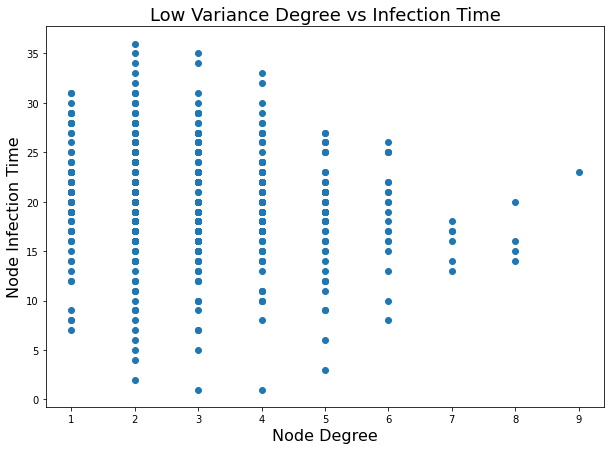

Correlation coefficient is: -0.13988540875884806


In [81]:
plot_degree_vs_infectiontime(low_var_G, xt_lv, 'Low Variance Degree vs Infection Time', 'C0')

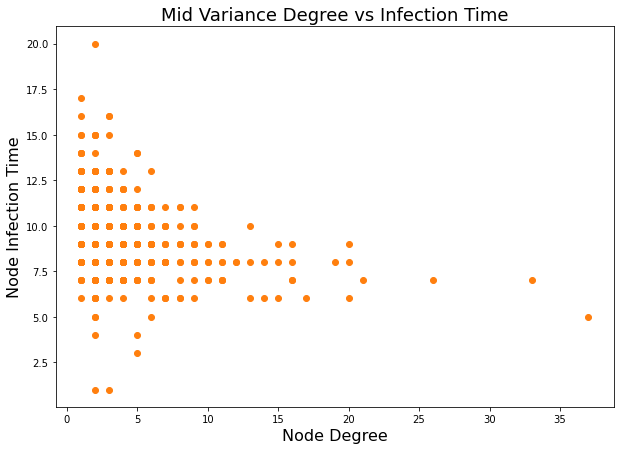

Correlation coefficient is: -0.3190789268691384


In [82]:
plot_degree_vs_infectiontime(mid_var_G, xt_mv, 'Mid Variance Degree vs Infection Time', 'C1')

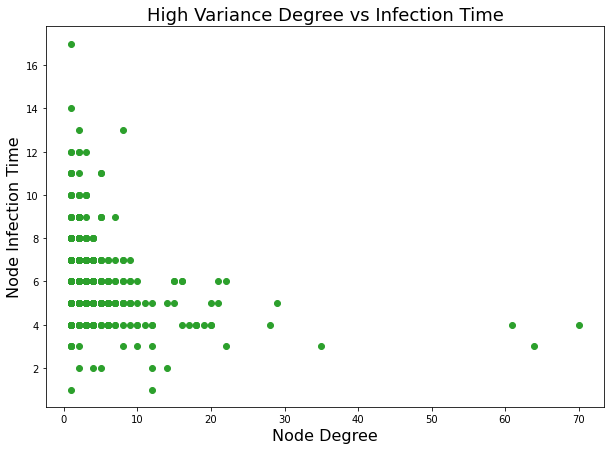

Correlation coefficient is: -0.27098963929917674


In [83]:
plot_degree_vs_infectiontime(high_var_G, xt_hv, 'High Variance Degree vs Infection Time', 'C2')

From these graphs, we can see that in general all of them exhibit the trend that node degree is inversely related to infection time. That is, higher degree nodes tend to be infected earlier. In the different graphs we can notice different things:
* **LOW VARIANCE:** The maximum node degree is 9 and the maximum infection time is 36. Although in general the higher degree nodes are infected earlier, the correlation coefficient in this case is not all that negative. This is because we see low variance in node degrees, so there simply are not that many nodes to get infected later.
* **MID VARIANCE:** The maximum node degree is 40 and the maximum infection time is 20. This graph exhibits a significantly more negative trend than the first graph, because the trend has more distance on the x-axis to develop, but also because the variance is not so high that the higher-degree nodes seem like outliers in the calculation of the correlation coefficient.
* **HIGH VARIANCE:** The maximum node degree is 70 and the max infection time is 17. In this graph, we still see a high negative trend, but it is less negative than the mid-variance version because the higher degree nodes have *significantly* higher degree than most of the nodes in the graph, so they seem like outliers in the calculation of the correlation coefficient.

We see similar trends as before (but visualized in a different way). Higher variance contributes to the existence of higher degree nodes, which shortens the time it takes for the epidemic to ravage the population. The negative correlation coefficients indicate that the higher degree you are as a node, in general the earlier in the course of the epidemic you will be infected. Again this makes sense, because higher degree nodes are connected to more potentially infected others who might transmit the disease to them.

***
### Problem 2-D (*10 pts extra credit*) : Flattening an epidemic

Complete this section of the in-class lab.

Using your SIR simulation, conduct the following three mini-experiments. For these, use the built-in `.gnp_random_graph(n, p)` network generator in `networkx`. Recall that `p` is the probability that an edge exists, and we choose it by first choosing the _mean degree_ $c$ (see Lecture Notes 3). The idea here is that the first experiment sets up your baseline for an SIR epidemic on a network, and then we'll first vary one parameter, and then vary a different parameter, to investigate the effects these parameters have on the dynamics of the epidemic. To do this, you'll want to plot the $S(t)$, $I(t)$, $R(t)$ functions after each simulation.

Experiment 3.1: simulate a basic epidemic:
* set $n=200$ and $c=6$
* note around what time step $I(t)$ peaks, and how many time steps it mostly spans.

Experiment 3.2: simulate the effect of reduced transmission (e.g., hand washing!):
* lower $\beta$; keep $\gamma$ the same, $n=200$ and $c=6$

Experiment 3.3: simulate the effect of "social distancing" (e.g., self-quarantine, staying at home, etc.):
* lower $c$ in $G(n,p)$; keep $\beta=\gamma$, $n=200$

As before, you'll want to run each setting several times to get a sense of what the epidemic tends to do. Start by lowering $\beta$ and $c$ only a little, and then keep lowering them until you see something change. Then, discuss with your teammates what you found, and answer the following specific questions:
1. What effect does lowering $\beta$ (reducing the likelihood of transmission) have on $I(t)$, compared to experiment 3.1? How much reduced transmission would you need _everyone_ to do to achieve a real "flattening" of the epidemic? Do you think that's realistic?
* What effect does lowering $c$ (reducing the likelihood of transmission) have on $I(t)$?, compared to experiment 3.1? How much social distancing would you need_everyone_ to do to achieve the results you found in experiment 3.3? (Consider what a typical $c$ might be for _you_ during a normal day. Is $c=6$ realistic?)
* Which has a larger effect on $I(t)$, reduced transmission or social distancing?

Experiment 1 - Control SIR Curve


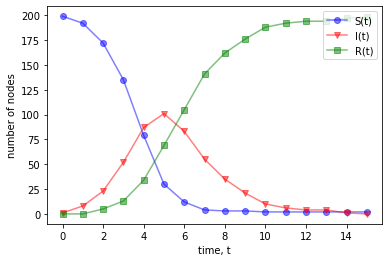

In [29]:
### EXPERIMENT 1
s = 1
beta = 0.4
gmma = 0.4
flag = 0
n = 200
c = 6
p = c / (n - 1)

exp1_G = nx.gnp_random_graph(n, p)

St_e1,It_e1,Rt_e1,xt_e1 = run_SIR(exp1_G,s,beta,gmma,flag)

print('Experiment 1 - Control SIR Curve')
plot_epidemicDynamics(St_e1,It_e1,Rt_e1)

This toy experiment takes 17.5 days to run the full course of the epidemic. The infection peaks around day 7 and the number of infected individuals gets up to half the population size. 

Experiment 2 - Impacts of Reduced Transmission Likelihood


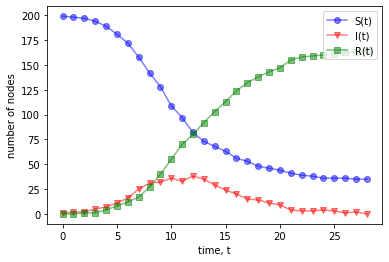

In [31]:
### EXPERIMENT 2 - LOWER BETA
s = 1
beta = 0.2 # I cut beta in half
gmma = 0.4
flag = 0
n = 200
c = 6
p = c / (n - 1)

exp2_G = nx.gnp_random_graph(n, p)

St_e2,It_e2,Rt_e2,xt_e2 = run_SIR(exp2_G,s,beta,gmma,flag)

print('Experiment 2 - Impacts of Reduced Transmission Likelihood')
plot_epidemicDynamics(St_e2,It_e2,Rt_e2)

Reducing beta made the time of the infection peak later (around 10 days instead of 7), as well as impacting the size of the peak, as the infection reached just over 1/4 of the total population rather than half the population like in experiment 3.1. It took longer for the infection to run its full course in this example.

Experiment 2 - Impacts of Reduced Transmission Likelihood


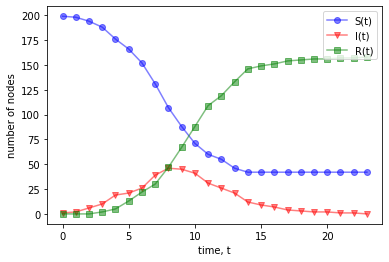

In [23]:
### EXPERIMENT 3 - LOWER AVERAGE DEGREE
s = 1
beta = 0.4
gmma = 0.4
flag = 0
n = 200
c = 3 # I cut c in half
p = c / (n - 1)

exp2_G = nx.gnp_random_graph(n, p)

St_e2,It_e2,Rt_e2,xt_e2 = run_SIR(exp2_G,s,beta,gmma,flag)

print('Experiment 2 - Impacts of Reduced Transmission Likelihood')
plot_epidemicDynamics(St_e2,It_e2,Rt_e2)

This experiment looks much more like experiment 3.2 than experiment 3.1. We can see that the infection peaked a bit earlier than 3.2, but the height of the peak was about 50 (1/4 of the population, like in the lower beta experiment).

The descriptions of each experiment can be seen in the markdown cells under the individual graphs. In order to see the results seen in experiments 3.2 and 3.3, every individual would need to reduce their transmission probability by 1/2 (3.2) or limit their contact with half the people they normally interact with (3.3). <br>

I do not think it is particularly reasonable to expect that every individual could reduce their transmission probability by half (there are a lot of people, and some people are in circumstances that prevent this from being possible like those who clean facilities and are just more frequently exposed). I do think, however, that practicing social distancing with half the people you normally see is relatively feasible, although again there are challenges for some based on the types of work they do (service industry, healthcare, etc.). This makes sense as to why it took so long to "flatten the curve" for COVID. In addition, we note that if the infection rate is already increasing rapidly, it is probably too late to flatten the curve. <br>

On my experiments, reducing beta and social distancing had pretty comparable impacts on the infection rate. It is hard to say which would be more impactful, but I would imagine in an interwoven society like ours social distancing is our best shot. This would help us cut transmission possibility, especially if people who have "high degree" practice social distancing and cut the number of people they come into contact with.

***
***

## Problem 3 : Reading the literature (*10 pts extra credit*)

Choose a paper from the [Supplemental Reading list on the external course webpage](https://aaronclauset.github.io/courses/3352/). Read the paper (the whole paper, not just the abstract). Think about what it says. Then, write 1-3 sentences for each of the following questions in a way that clearly summarizes the work, and its context.
* What paper did you choose?
* What was the research question?
* What was the approach the authors took to answer that question?
* What did they do well?
* What could they have done better?
* What extensions can you envision?


Do not copy any text from the paper itself; write your own summary, in your own words in Markdown in the corresponding box below. Be sure to answer each of the five questions. The amount of extra credit will depend on the accuracy and thoughtfulness of your answers.

Hint: This is a good way to generate some ideas for your class project (your proposal for that is due on **February 27th**. Also, even if you don't understand everything in the paper, that's okay. Do your best to summarize what you did understand.

* *What paper did you choose?*<br/>
Give the Authors, Title, Publication Venue, Year
<br/>

* *What was the research question?*<br/>
Your answer here
<br/>

* *What was the approach the authors took to answer that question?*<br/>
Your answer here
<br/>

* *What did they do well?*<br/>
Your answer here
<br/>

* *What could they have done better?*<br/>
Your answer here
<br/>

* *What extensions can you envision?*<br/>
Your answer here